# Import libraries

In [177]:
import spacy
import nltk
import re
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import os
from deep_translator import GoogleTranslator
from nltk.tokenize import sent_tokenize
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pandas as pd
import swifter

# Setting NLTK resources

In [178]:
# Define the NLTK data path
NLTK_DATA_PATH = os.path.expanduser("~/nltk_data")  # Change this path if needed

# Ensure the NLTK data directory exists
os.makedirs(NLTK_DATA_PATH, exist_ok=True)

# Function to check if a resource exists and download if missing
def download_nltk_resource(resource, subfolder="corpora"):
    resource_path = os.path.join(NLTK_DATA_PATH, subfolder, resource)
    if not os.path.exists(resource_path):
        print(f"Downloading {resource}...")
        nltk.download(resource, download_dir=NLTK_DATA_PATH)
    else:
        print(f"{resource} already exists, skipping download.")

# Check and download required NLTK resources
download_nltk_resource("stopwords.zip")
download_nltk_resource("punkt.zip", "tokenizers")
download_nltk_resource("vader_lexicon.zip", "sentiment")

# Set NLTK's data path
nltk.data.path.append(NLTK_DATA_PATH)

# Load the spaCy English model
nlp = spacy.load("en_core_web_sm")

# Initialize stopwords and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

stopwords.zip already exists, skipping download.
punkt.zip already exists, skipping download.
vader_lexicon.zip already exists, skipping download.


# Load the vectorizer and model

In [179]:
from joblib import load

tfidf_vectorizer_AE = load("../models/tfidf_vectorizer_AE.pkl")
SVM_opinion_category_classifier = load("../models/SVM_opinion_category_classifier.pkl")
tfidf_vectorizer_SA = load("../models/tfidf_vectorizer_SA.pkl")
svm_sentiment_classifier = load("../models/svm_sentiment_classifier.pkl")


In [180]:
# Set the option to display full column width and all rows
pd.set_option("display.max_colwidth",None)
pd.set_option("display.max_rows",None)

## Translate text into English

In [181]:
def translate(text):
    translator = GoogleTranslator(source='auto', target='en')
    return translator.translate(text)

text1 = "बढ़िया खाना था"
print(translate(text1))

the food was great


## Handling Emojies

In [182]:
import re

# Define emojis (expanded with your emojis)
positive_emojis = { "😄", "😀", "😁", "😆", "😂", "🤣", "😊", "🙂", "😎", "😉", "😍", "🥰", "😘", "😋", "😛", "😝", "😜", "🤪", "🤩", "🥳", "❤️", "👍", "👌", "🤟", "🍔", "🍕", "🍣", "🍰", "🍹", "🍷", "🍺", "🍦", "🍯", "🥞", "🍟", "🍩", "🥼", "🎉", "🎊", "🥳", "🍚", "🍘", "🍥", "🥠", "🥮", "🍢", "🍡", "🍧", "🍨", "🍦", "🥧", "🧁", "🍰", "🎂", "🍮", "🍭", "🍬", "🍫", "🍿", "🍩", "🍪", "🌰", "🥜", "🍯", "🍻", "🥂", "🍷", "🍾", "😇", "🤒", "👏"}
negative_emojis = { "😔", "😞", "😢", "😭", "😤", "😠", "😡", "🤬", "😩", "😫", "🥺", "😖", "😣", "😠", "😤", "😷", "🤒", "🤕", "😐", "😶", "😒", "😏", "🙁", "🥶", "😨", "😱", "😰", "😳", "🥵", "😳", "😵", "🤯", "🤐", "🤮", "🥴", "🤢", "👎", "😈", "👿", "💔", "😩", "😔", "😞", "😢", "😭" }

# Add space between word and emoji
def handle_emoji(sentence):
    # Regex pattern for positive and negative emojis
    emoji_pattern = re.compile(r'|'.join(map(re.escape, positive_emojis | negative_emojis)))
    
    # Replace emojis with respective labels
    def replace_emoji(match):
        emoji_char = match.group(0)
        if emoji_char in positive_emojis:
            return "good"
        elif emoji_char in negative_emojis:
            return "bad"
        return emoji_char  # This case should never occur as we handle all emojis

    # Replace emojis in sentence
    sentence = emoji_pattern.sub(replace_emoji, sentence)
    
    return sentence

# # Example usage:
# input_sentence = "😀"

# input_sentence = "बढ़िया खाना था😀"
# input_sentence = "The food was good 😊 but the service was bad 😡."
# converted = handle_emoji(input_sentence)
# print(converted)  # Expected output: "बढ़िया खाना था good"


# Data PreProcessing

In [183]:
# Data Cleaning
def clean_text(text):
    if text is not None:
        text = text.lower() # Lowercase the text
        text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)   # Remove special characters and punctuation
    return text

# Text preprocessing functions
def preprocess_text(text, state=0):
    if state == 1:
        text = translate(text)
    if text:
        text = handle_emoji(text)
        text = clean_text(text)
        doc = nlp(text)
        text = " ".join([token.lemma_ for token in doc if (not token.is_stop or token.text.lower()  =="not") and len(token.text) > 2])
        return text if len(text.split()) > 1 else ""
    return ""
# print(preprocess_text("this is  not good if"))

### Function to tokenize text into sentences

In [184]:
def split_complex_sentence(texts):
    if isinstance(texts, str):  # If a single string is passed, convert it to a list
        texts = [texts]

    simpler_sentences = []
    for doc in nlp.pipe(texts, batch_size=100):  # Process texts in batches
        temp_sentence = []
        for token in doc:
            if token.dep_ == "cc":  # Coordinating conjunction (splitting criterion)
                if temp_sentence:
                    simpler_sentences.append(" ".join(temp_sentence))
                temp_sentence = []
            else:
                temp_sentence.append(token.text)
        if temp_sentence:
            simpler_sentences.append(" ".join(temp_sentence))
    return simpler_sentences

# # Example usage
# text = "The service at the restaurant was excellent. The food was also good but atmosphere was not good."
# simplified_sentences = split_complex_sentence(text)
# for sen in simplified_sentences:
#     print(sen)


# Load Unlabeled dataset [ Define filename if you are running this file directly ]

In [185]:
input_df = pd.read_csv("../datasets/testing_dataset/First_Restaurant_Review_dataset.csv")

In [186]:
input_df.head()

,Wow... Loved this place.
0,Crust is not good.
1,Not tasty and the texture was just nasty.
2,Stopped by during the late May bank holiday off Rick Steve recommendation and loved it.
3,The selection on the menu was great and so were the prices.
4,Now I am getting angry and I want my damn pho.


### Add index to the DataFrame

In [187]:
input_df['idx'] = range(10, (len(input_df) + 1)*10, 10)
input_df.columns = ['Review', 'idx']
input_df.head()

,Review,idx
0,Crust is not good.,10
1,Not tasty and the texture was just nasty.,20
2,Stopped by during the late May bank holiday off Rick Steve recommendation and loved it.,30
3,The selection on the menu was great and so were the prices.,40
4,Now I am getting angry and I want my damn pho.,50


### Converting every Review text into simple sentences and forming new dataframe as discussed earlier

In [188]:
input_df['Simplified_Review'] = input_df['Review'].apply(lambda x: split_complex_sentence(x))
input_df = input_df.explode('Simplified_Review')

# Drop the original 'Review' column and rename the simplified column as 'Review'
input_df = input_df.drop(columns=['Review']).rename(columns={'Simplified_Review': 'Review'})

input_df.head() # print dataset head

,idx,Review
0,10,Crust is not good .
1,20,Not tasty
1,20,the texture was just nasty .
2,30,Stopped by during the late May bank holiday off Rick Steve recommendation
2,30,loved it .


### Preprocessing Review to create new column cleaned_review

In [189]:
from multiprocessing import Pool
import numpy as np

def parallel_apply(df, func, num_partitions=5):
    """Applies a function to a dataframe in parallel using multiprocessing."""
    df_split = [df.iloc[i::num_partitions] for i in range(num_partitions)]
 # Split into partitions
    with Pool(num_partitions) as pool:
        df = pd.concat(pool.map(func, df_split))  # Apply function in parallel
    return df

# Ensure preprocess_text works on a dataframe partition
def preprocess_dataframe(df):
    df['Cleaned_Review'] = df['Review'].apply(preprocess_text)  # Apply text processing
    return df

# Apply preprocessing in parallel
input_df = parallel_apply(input_df, preprocess_dataframe)


input_df.head()

,idx,Review,Cleaned_Review
0,10,Crust is not good .,crust not good
3,40,The selection on the menu was great,selection menu great
6,70,The potatoes were like rubber,potato like rubber
10,110,Would not go back .,
15,160,Highly recommended .,highly recommend


### Deleting rows where cleaned_review column is empty

In [190]:
input_df = input_df[input_df['Cleaned_Review'] != ""]
# input_df

### Drop the custom index and reset to the default integer-based index

In [191]:
input_df.reset_index(drop=True, inplace=True)

### Rearrange the column order

In [192]:
# Create a list of column names in the desired order
desired_order = ['idx', 'Review', 'Cleaned_Review']

# Rearrange the columns
input_df = input_df[desired_order]

# Opinion Target (Aspect) Extraction

In [193]:
# Aspect extraction function
def extract_aspect(sentence):
    # Use Spacy to process the sentence
    doc = nlp(sentence)
    
    target = ''
    temp_target = ''

    # Loop through tokens and extract the subject (noun)
    for token in doc:
        if token.dep_ == 'nsubj' and token.pos_ == 'NOUN':
            target = token.text
        if target == '' and token.pos_ == 'NOUN':
            temp_target = token.text

    if target == '': 
        target = temp_target

    return target

# Multiprocessing apply function
def parallel_apply(df, func, num_partitions=4):
    df_split = np.array_split(df, num_partitions)
    with Pool(num_partitions) as pool:
        result = pd.concat(pool.map(func, df_split))
    return result

# Function to apply 'extract_aspect' row by row
def apply_extract_aspect(df):
    df['Opinion_Target'] = df['Review'].apply(extract_aspect)
    return df

# Apply aspect extraction in parallel
input_df = parallel_apply(input_df, apply_extract_aspect)

input_df.head()

,idx,Review,Cleaned_Review,Opinion_Target
0,10,Crust is not good .,crust not good,Crust
1,40,The selection on the menu was great,selection menu great,selection
2,70,The potatoes were like rubber,potato like rubber,potatoes
3,160,Highly recommended .,highly recommend,
4,210,"The food , amazing .",food amazing,food


# Predict the Opinion_Category 

In [194]:
# Vectorize the Opinion_Target using the  tfidf_vectorizer
sample_tfidf = tfidf_vectorizer_AE.transform(input_df['Opinion_Target'])

# Predicting the Opinion_Category 
predicted_aspect_category = SVM_opinion_category_classifier.predict(sample_tfidf)

# adding column Opinion_Category
input_df['Opinion_Category'] = predicted_aspect_category

# unique values of Opinion_Category 
input_df['Opinion_Category'].value_counts()

Opinion_Category
FOOD#QUALITY                955
SERVICE#GENERAL             111
RESTAURANT#GENERAL           89
AMBIENCE#GENERAL             36
FOOD#STYLE_OPTIONS           22
DRINKS#QUALITY                7
RESTAURANT#MISCELLANEOUS      7
LOCATION#GENERAL              2
DRINKS#STYLE_OPTIONS          1
Name: count, dtype: int64

In [195]:
input_df.head()

,idx,Review,Cleaned_Review,Opinion_Target,Opinion_Category
0,10,Crust is not good .,crust not good,Crust,FOOD#QUALITY
1,40,The selection on the menu was great,selection menu great,selection,FOOD#QUALITY
2,70,The potatoes were like rubber,potato like rubber,potatoes,FOOD#QUALITY
3,160,Highly recommended .,highly recommend,,FOOD#QUALITY
4,210,"The food , amazing .",food amazing,food,FOOD#QUALITY


### Handle missing values of Opinion_Target Column 

In [196]:
# Opinion_Target = "" and Opinion_Category = "FOOD#QUALITY" then food of before # is Opinion_Target
# Assumption just  to handle missing value
def missing_value_handler(df):
    return df['Opinion_Category'].split('#')[0].lower() if pd.isna(df['Opinion_Target']) else df['Opinion_Target']

input_df['Opinion_Target'] = input_df.apply(missing_value_handler, axis = 1)

In [197]:
# input_df

# Predict the Opinion_Polarity

In [198]:
# Vectorize the sample sentence using the same tfidf_vectorizer
sample_tfidf = tfidf_vectorizer_SA.transform(input_df['Cleaned_Review'])

# Predict the sentiment for the sample sentence
Predicted_Opinion_Polarity = svm_sentiment_classifier.predict(sample_tfidf)

# adding new column Opinion_Polarity in dataset
input_df['Opinion_Polarity'] = Predicted_Opinion_Polarity


In [199]:
# print dataset
input_df.tail()

,idx,Review,Cleaned_Review,Opinion_Target,Opinion_Category,Opinion_Polarity
1225,9830,It sure does beat the nachos at the movies,sure beat nachos movie,movies,FOOD#QUALITY,positive
1226,9860,Shrimp- When I unwrapped it ( I live only 1/2 a mile from Brushfire ) it was literally ice cold .,shrimp unwrap live mile brushfire literally ice cold,ice,FOOD#QUALITY,positive
1227,9900,The refried beans that came with my meal were dried out,refrie bean come meal dry,meal,FOOD#QUALITY,negative
1228,9920,A lady at the table next to us found a live green caterpillar In her salad .,lady table find live green caterpillar salad,lady,FOOD#QUALITY,positive
1229,9980,I think we 'll just go to Ninja Sushi next time .,think ninja sushi time,time,FOOD#QUALITY,positive


# Charts

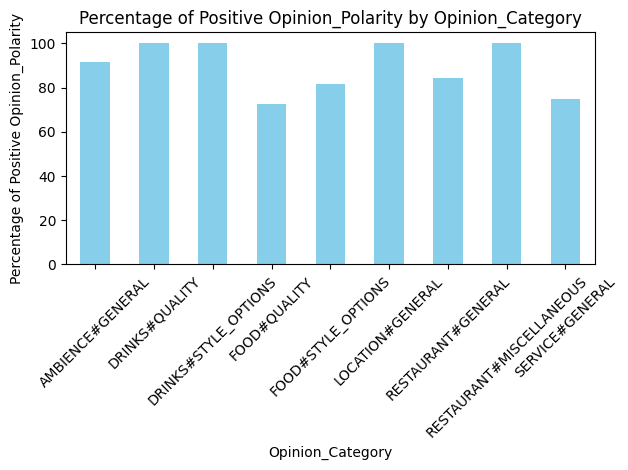

In [200]:
import matplotlib.pyplot as plt
# Group the DataFrame by 'Opinion_Category' and 'Opinion_Polarity' and count occurrences
grouped = input_df.groupby(['Opinion_Category', 'Opinion_Polarity']).size().unstack(fill_value=0)

# Calculate the percentage of positive Opinion_Polarity for each Opinion_Category
grouped['Percentage of Positive Opinion_Polarity'] = (grouped['positive'] / (grouped['positive'] + grouped['negative'])) * 100

# Plot the percentage of positive Opinion_Polarity for each Opinion_Category
ax = grouped['Percentage of Positive Opinion_Polarity'].plot(kind='bar', color='skyblue')
ax.set_xlabel('Opinion_Category')
ax.set_ylabel('Percentage of Positive Opinion_Polarity')
plt.title('Percentage of Positive Opinion_Polarity by Opinion_Category')
plt.xticks(rotation=45)
plt.tight_layout()
# plt.savefig('output/images/sample_plot.jpg')
plt.show()

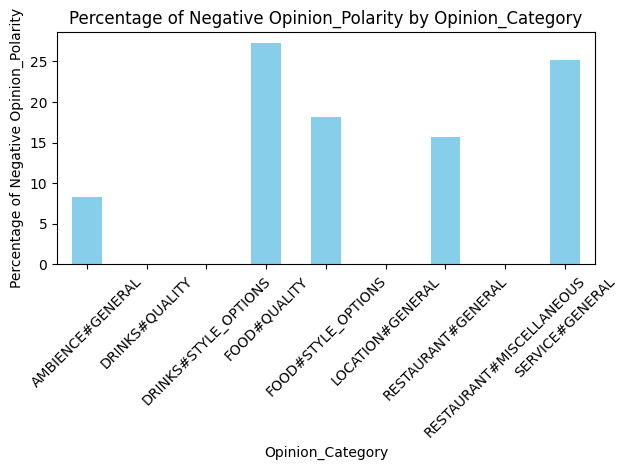

In [201]:
# Group the DataFrame by 'Opinion_Category' and 'Opinion_Polarity' and count occurrences
grouped = input_df.groupby(['Opinion_Category', 'Opinion_Polarity']).size().unstack(fill_value=0)

# Calculate the percentage of positive Opinion_Polarity for each Opinion_Category
grouped['Percentage of Negative Opinion_Polarity'] = (grouped['negative'] / (grouped['positive'] + grouped['negative'])) * 100

# Plot the percentage of positive Opinion_Polarity for each Opinion_Category
ax = grouped['Percentage of Negative Opinion_Polarity'].plot(kind='bar', color='skyblue')
ax.set_xlabel('Opinion_Category')
ax.set_ylabel('Percentage of Negative Opinion_Polarity')
plt.title('Percentage of Negative Opinion_Polarity by Opinion_Category')
plt.xticks(rotation=45)
plt.tight_layout()
# plt.savefig('output/images/sample_plot1.jpg')
plt.show()
 

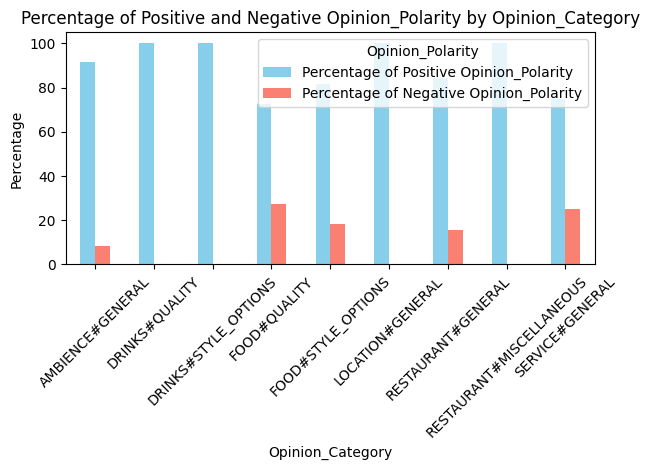

In [202]:

# Group the DataFrame by 'Opinion_Category' and 'Opinion_Polarity' and count occurrences
grouped = input_df.groupby(['Opinion_Category', 'Opinion_Polarity']).size().unstack(fill_value=0)

# Calculate the percentage of positive and negative Opinion_Polarity for each Opinion_Category
grouped['Percentage of Positive Opinion_Polarity'] = (grouped['positive'] / (grouped['positive'] + grouped['negative'])) * 100
grouped['Percentage of Negative Opinion_Polarity'] = (grouped['negative'] / (grouped['positive'] + grouped['negative'])) * 100

# Plot the percentages of positive and negative Opinion_Polarity for each Opinion_Category
ax = grouped[['Percentage of Positive Opinion_Polarity', 'Percentage of Negative Opinion_Polarity']].plot(kind='bar', color=['skyblue', 'salmon'])
ax.set_xlabel('Opinion_Category')
ax.set_ylabel('Percentage')
plt.title('Percentage of Positive and Negative Opinion_Polarity by Opinion_Category')
plt.xticks(rotation=45)
plt.tight_layout()
# plt.savefig('output/images/sample_plot2.jpg')
plt.show()

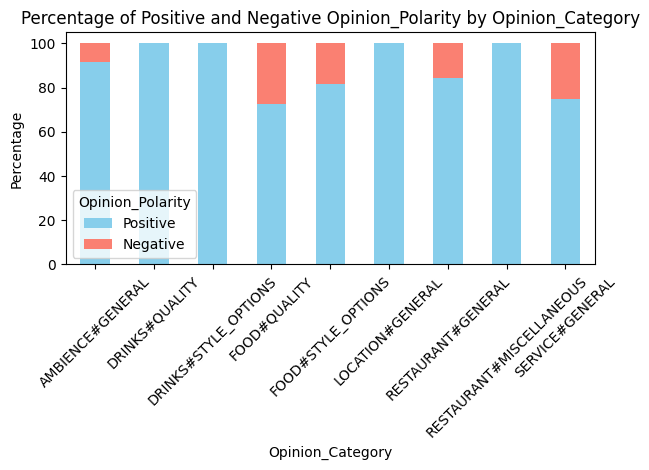

In [203]:
import matplotlib.pyplot as plt

# Group the DataFrame by 'Opinion_Category' and 'Opinion_Polarity' and count occurrences
grouped = input_df.groupby(['Opinion_Category', 'Opinion_Polarity']).size().unstack(fill_value=0)

# Calculate the percentage of positive and negative Opinion_Polarity for each Opinion_Category
grouped['Percentage of Positive Opinion_Polarity'] = (grouped['positive'] / (grouped['positive'] + grouped['negative'])) * 100
grouped['Percentage of Negative Opinion_Polarity'] = (grouped['negative'] / (grouped['positive'] + grouped['negative'])) * 100

# Plot a stacked bar chart for the percentages
ax = grouped[['Percentage of Positive Opinion_Polarity', 'Percentage of Negative Opinion_Polarity']].plot(kind='bar', stacked=True, color=['skyblue', 'salmon'])
ax.set_xlabel('Opinion_Category')
ax.set_ylabel('Percentage')
plt.title('Percentage of Positive and Negative Opinion_Polarity by Opinion_Category')
plt.xticks(rotation=45)
plt.tight_layout()

# Add a legend
plt.legend(title='Opinion_Polarity', labels=['Positive', 'Negative'])

# Save the chart as an image
# plt.savefig('output/images/sample_stacked_bar_chart.jpg')

# Show the chart
plt.show()


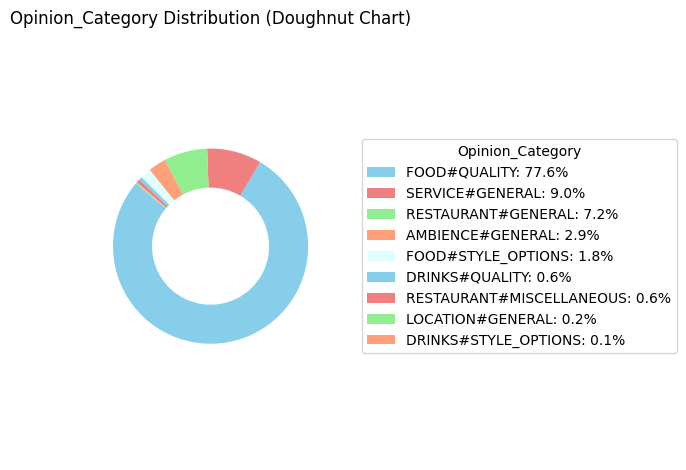

In [204]:
import matplotlib.pyplot as plt
import pandas as pd

# Group the DataFrame by 'Opinion_Category' and count occurrences
grouped = input_df['Opinion_Category'].value_counts().reset_index()
grouped.columns = ['Opinion_Category', 'Count']

# Calculate the percentage of total reviews for each category
grouped['Percentage of Total Reviews'] = (grouped['Count'] / grouped['Count'].sum()) * 100

# Set colors for the doughnut chart
colors = ['skyblue', 'lightcoral', 'lightgreen', 'lightsalmon', 'lightcyan']

# Create a doughnut chart for Opinion_Category Distribution
fig, ax = plt.subplots()

# Plot the pie chart (outer circle)
wedges, texts, autotexts = ax.pie(
    grouped['Count'],
    labels=None,  # No labels on slices
    autopct='',
    startangle=140,
    colors=colors,
    wedgeprops=dict(width=0.4)  # Set the width to create a doughnut chart
)

# Add a legend with color-coded labels and percentages in a table
legend_labels = [f'{category}: {percentage:.1f}%' for category, percentage in zip(grouped['Opinion_Category'], grouped['Percentage of Total Reviews'])]
ax.legend(wedges, legend_labels, loc="center left", bbox_to_anchor=(1, 0.5), title="Opinion_Category")

plt.axis('equal')
plt.title('Opinion_Category Distribution (Doughnut Chart)')

plt.tight_layout()
# plt.savefig('output/images/opinion_category_doughnut_chart.jpg')
plt.show()


                          negative  positive  \
Opinion_Category                               
AMBIENCE#GENERAL                 3        33   
DRINKS#QUALITY                   0         7   
DRINKS#STYLE_OPTIONS             0         1   
FOOD#QUALITY                   260       695   
FOOD#STYLE_OPTIONS               4        18   
LOCATION#GENERAL                 0         2   
RESTAURANT#GENERAL              14        75   
RESTAURANT#MISCELLANEOUS         0         7   
SERVICE#GENERAL                 28        83   

                          Percentage of Positive Opinion_Polarity  \
Opinion_Category                                                    
AMBIENCE#GENERAL                                        91.666667   
DRINKS#QUALITY                                         100.000000   
DRINKS#STYLE_OPTIONS                                   100.000000   
FOOD#QUALITY                                            72.774869   
FOOD#STYLE_OPTIONS                                      8

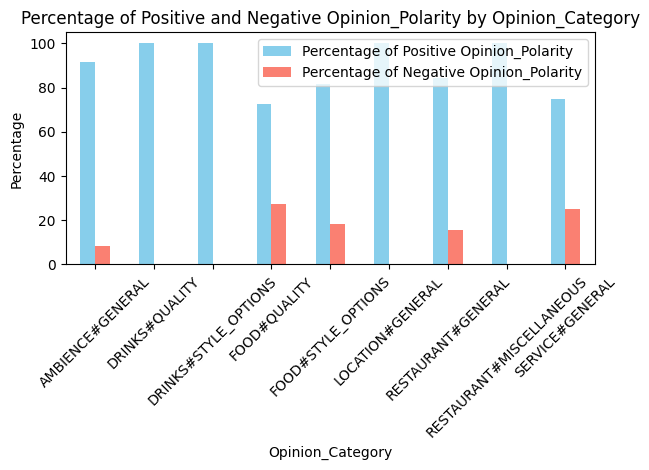

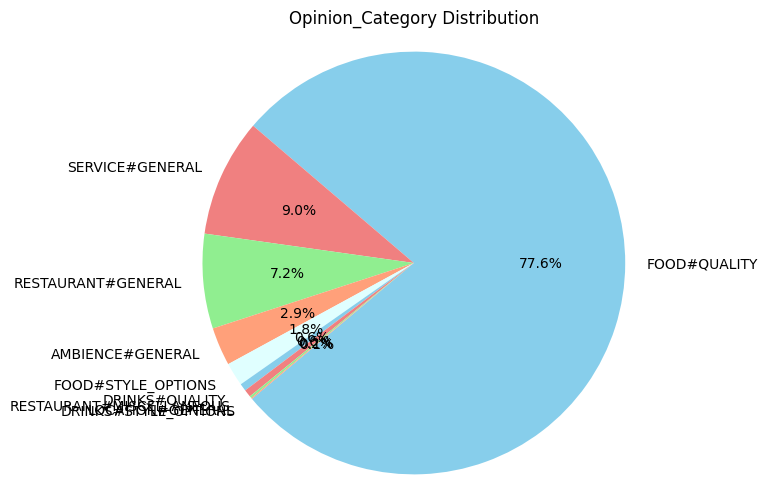

In [205]:
# Group the DataFrame by 'Opinion_Category' and 'Opinion_Polarity' and count occurrences
grouped = input_df.groupby(['Opinion_Category', 'Opinion_Polarity']).size().unstack(fill_value=0)

# Calculate the percentage of positive and negative Opinion_Polarity for each Opinion_Category
grouped['Percentage of Positive Opinion_Polarity'] = (grouped['positive'] / (grouped['positive'] + grouped['negative'])) * 100
grouped['Percentage of Negative Opinion_Polarity'] = (grouped['negative'] / (grouped['positive'] + grouped['negative'])) * 100

# Group the DataFrame by 'Aspect' and count occurrences
grouped_aspect = input_df['Opinion_Category'].value_counts().reset_index()
grouped_aspect.columns = ['Opinion_Category', 'Count']

# Calculate the percentage of each Opinion_Category in the total reviews
grouped_aspect['Percentage of Total Reviews'] = (grouped_aspect['Count'] / grouped_aspect['Count'].sum()) * 100

# Create a summary table
summary_table = grouped.join(grouped_aspect.set_index('Opinion_Category'), on='Opinion_Category')
summary_table['Percentage of Total Reviews'] = summary_table['Percentage of Total Reviews'].fillna(0)

# Print the summary table
print(summary_table)

# Plot the percentages of positive and negative Opinion_Polarity for each Opinion_Category
ax = summary_table[['Percentage of Positive Opinion_Polarity', 'Percentage of Negative Opinion_Polarity']].plot(kind='bar', color=['skyblue', 'salmon'])
ax.set_xlabel('Opinion_Category')
ax.set_ylabel('Percentage')
plt.title('Percentage of Positive and Negative Opinion_Polarity by Opinion_Category')
plt.xticks(rotation=45)
plt.tight_layout()
# plt.savefig('static/images/sample_plot2.jpg')

# Plot the pie chart for Opinion_Category Distribution
plt.figure(figsize=(6, 6))
plt.pie(grouped_aspect['Count'], labels=grouped_aspect['Opinion_Category'], autopct='%1.1f%%', startangle=220, colors=['skyblue', 'lightcoral', 'lightgreen', 'lightsalmon', 'lightcyan'])
plt.title('Opinion_Category Distribution')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
# plt.savefig('output/images/sample_plot7.jpg')
plt.show()


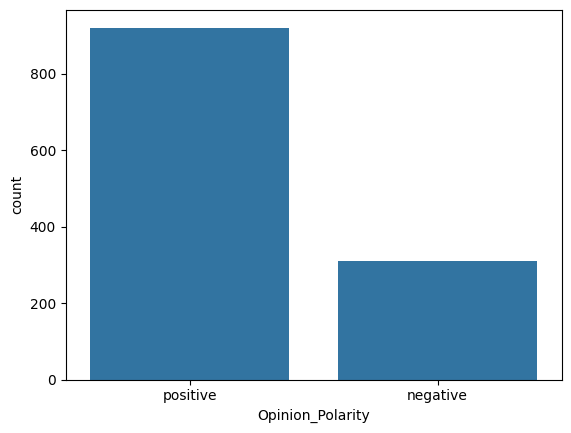

In [206]:
# Opinion_Polarity distribution in our dataset
# df.Opinion_Polarity.value_counts().sort_values().plot(kind = 'bar')
sns.countplot(x = "Opinion_Polarity", data = input_df)
plt.show()

### --------------------------------XxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxX-------------------------------------

# Aspect and Sentiment analysis for a random text

### Text

In [207]:
text = "The pizza is delicious but service is terrible. The atmosphere is also not good.😀"
text = '''I recently dined at this restaurant, and I must say the food was excellent. 
The steak was perfectly cooked and very flavorful. However, the service was unsatisfactory.
The waitstaff seemed disorganized, and our orders took longer than expected. Despite that,
the ambiance of the restaurant was lovely, and the dessert was a delightful ending to the meal. Overall, 
a mixed experience'''
# text = "बढ़िया खाना था😀"
# text = "food😀"
# text = "the food is tasty!!!"

In [215]:
import multiprocessing


def extract_aspects(sentence):
    """Extract aspects from a single sentence."""
    important = nlp(sentence)
    target = ''
    for token in important:
        if token.dep_ == 'nsubj' and token.pos_ == 'NOUN':
            target = token.text
        elif token.pos_ == 'NOUN':
            target = token.text
    return target if target else "restaurant"  # Default if no aspect found

def analyze_sentiment(sentence):
    """Analyze sentiment of a single sentence."""
    sid = SentimentIntensityAnalyzer()
    sentiment_scores = sid.polarity_scores(sentence)
    if sentiment_scores['compound'] >= 0.05:
        return "positive"
    elif sentiment_scores['compound'] <= -0.05:
        return "negative"
    else:
        return "neutral"

def absa_random(text):
    """Perform aspect-based sentiment analysis with multiprocessing."""
    
    # Breaking complex sentence into simple sentences
    simplified_sentences = split_complex_sentence(preprocess_text(text, 1))
    
    # Multiprocessing for Aspect Extraction
    with multiprocessing.Pool(processes=multiprocessing.cpu_count()) as pool:
        aspects = pool.map(extract_aspects, simplified_sentences)
    
    # Vectorize the extracted aspects using the pre-fitted TF-IDF Vectorizer
    aspects_tfidf = tfidf_vectorizer_AE.transform(aspects)

    # Predict the Opinion Category for each aspect
    predicted_aspects = SVM_opinion_category_classifier.predict(aspects_tfidf)

    # Multiprocessing for Sentiment Analysis
    with multiprocessing.Pool(processes=multiprocessing.cpu_count()) as pool:
        predicted_sentiments = pool.map(analyze_sentiment, simplified_sentences)
    
    # Return the results in a formatted structure
    result = "\n".join([f"Aspect: {aspect}, Category: {category}, Sentiment: {sentiment}"
                        for aspect, category, sentiment in zip(aspects, predicted_aspects, predicted_sentiments)])

    return result

# Example usage
text = "The pizza is delicious but the service is terrible. The atmosphere is also not good.😀"
print(absa_random(text))


Aspect: goodgood, Category: FOOD#QUALITY, Sentiment: positive
